Dependencies

In [15]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder,MinMaxScaler,StandardScaler
from sklearn.compose import ColumnTransformer
import seaborn as sns       
import numpy as np
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer,KNNImputer,SimpleImputer
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,VotingClassifier
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,roc_auc_score
from sklearn.model_selection import cross_val_score,GridSearchCV,RandomizedSearchCV,train_test_split
from xgboost import XGBClassifier
from sklearn.feature_selection import mutual_info_classif
from lightgbm import LGBMClassifier
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

Dataset

In [16]:
df=pd.read_csv('employee_promotion.csv')
df

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,0,49.0,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,60.0,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,50.0,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,50.0,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,73.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54803,3030,Technology,region_14,Bachelor's,m,sourcing,1,48,3.0,17,0,78.0,0
54804,74592,Operations,region_27,Master's & above,f,other,1,37,2.0,6,0,56.0,0
54805,13918,Analytics,region_1,Bachelor's,m,other,1,27,5.0,3,0,79.0,0
54806,13614,Sales & Marketing,region_9,NaN,m,sourcing,1,29,1.0,2,0,NaN,0


Region feature is removed as it provides less information and value for the computation complexity it has due to high cardinality.

In [17]:
m=df.groupby('region')['is_promoted'].mean()*100
r=df.groupby('region').count()
r=r[['is_promoted']]
r['promoted']=m
r.rename(columns={"is_promoted":"count"},inplace=True)
r

,count,promoted
region,,
region_1,610,9.508197
region_10,648,7.870370
region_11,1315,5.627376
region_12,500,6.600000
region_13,2648,8.685801
region_14,827,7.496977
region_15,2808,7.905983
region_16,1465,6.962457
region_17,796,13.693467


In [18]:
df=df.drop(['employee_id','region'],axis=1)
df

,department,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score,is_promoted
0,Sales & Marketing,Master's & above,f,sourcing,1,35,5.0,8,0,49.0,0
1,Operations,Bachelor's,m,other,1,30,5.0,4,0,60.0,0
2,Sales & Marketing,Bachelor's,m,sourcing,1,34,3.0,7,0,50.0,0
3,Sales & Marketing,Bachelor's,m,other,2,39,1.0,10,0,50.0,0
4,Technology,Bachelor's,m,other,1,45,3.0,2,0,73.0,0
...,...,...,...,...,...,...,...,...,...,...,...
54803,Technology,Bachelor's,m,sourcing,1,48,3.0,17,0,78.0,0
54804,Operations,Master's & above,f,other,1,37,2.0,6,0,56.0,0
54805,Analytics,Bachelor's,m,other,1,27,5.0,3,0,79.0,0
54806,Sales & Marketing,NaN,m,sourcing,1,29,1.0,2,0,NaN,0


Missing values

In [19]:
df.isna().sum()

department                 0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4124
length_of_service          0
awards_won                 0
avg_training_score      2560
is_promoted                0
dtype: int64

education and avg_training_score is missing at random,  
previous_year_rating is missing when length_of_service=1, i.e, employee is in first year of service

In [20]:
d=df[df.length_of_service==1]
print(d.previous_year_rating.isna().sum())
d

4124


,department,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score,is_promoted
10,Technology,NaN,m,sourcing,1,30,NaN,1,0,77.0,0
23,Procurement,Bachelor's,m,other,1,27,NaN,1,0,70.0,0
29,Sales & Marketing,Bachelor's,m,sourcing,1,26,NaN,1,0,44.0,0
56,Sales & Marketing,Bachelor's,f,other,1,29,NaN,1,0,49.0,0
58,Sales & Marketing,Bachelor's,m,other,2,27,NaN,1,0,47.0,0
...,...,...,...,...,...,...,...,...,...,...,...
54703,R&D,Bachelor's,m,sourcing,1,30,NaN,1,0,88.0,0
54734,Operations,Bachelor's,m,sourcing,1,31,NaN,1,0,56.0,1
54746,Finance,Bachelor's,m,other,1,28,NaN,1,0,NaN,0
54773,Finance,Bachelor's,m,other,1,23,NaN,1,0,NaN,0


Drop the few rows where previous year rating is provided even when length_of_service=1 ( Data Cleaning )

In [21]:
d2=d[d.previous_year_rating.isna()==False]
d2

,department,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score,is_promoted
439,Legal,Bachelor's,m,other,1,31,3.0,1,0,62.0,0
461,Sales & Marketing,Master's & above,f,sourcing,1,31,3.0,1,0,54.0,0
526,Operations,Bachelor's,f,sourcing,1,25,3.0,1,0,62.0,0
536,R&D,Bachelor's,m,sourcing,1,30,5.0,1,0,96.0,1
784,Sales & Marketing,Master's & above,f,other,1,31,3.0,1,0,47.0,0
...,...,...,...,...,...,...,...,...,...,...,...
54509,Sales & Marketing,Bachelor's,m,other,2,26,3.0,1,0,50.0,0
54566,Technology,Bachelor's,m,sourcing,1,25,4.0,1,0,74.0,0
54587,Operations,NaN,m,sourcing,1,27,2.0,1,0,59.0,0
54631,Finance,Bachelor's,f,other,1,27,3.0,1,0,NaN,0


In [22]:
df=df.drop(d2.index)
df

,department,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score,is_promoted
0,Sales & Marketing,Master's & above,f,sourcing,1,35,5.0,8,0,49.0,0
1,Operations,Bachelor's,m,other,1,30,5.0,4,0,60.0,0
2,Sales & Marketing,Bachelor's,m,sourcing,1,34,3.0,7,0,50.0,0
3,Sales & Marketing,Bachelor's,m,other,2,39,1.0,10,0,50.0,0
4,Technology,Bachelor's,m,other,1,45,3.0,2,0,73.0,0
...,...,...,...,...,...,...,...,...,...,...,...
54803,Technology,Bachelor's,m,sourcing,1,48,3.0,17,0,78.0,0
54804,Operations,Master's & above,f,other,1,37,2.0,6,0,56.0,0
54805,Analytics,Bachelor's,m,other,1,27,5.0,3,0,79.0,0
54806,Sales & Marketing,NaN,m,sourcing,1,29,1.0,2,0,NaN,0


Missing value indicator for previous_year_rating feature

In [23]:
df.previous_year_rating=df.previous_year_rating.fillna(99)
df.previous_year_rating.value_counts()

3.0     18460
5.0     11677
4.0      9763
1.0      6179
2.0      4182
99.0     4124
Name: previous_year_rating, dtype: int64

In [24]:
df['first_year']=df.length_of_service.eq(1)
df

,department,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score,is_promoted,first_year
0,Sales & Marketing,Master's & above,f,sourcing,1,35,5.0,8,0,49.0,0,False
1,Operations,Bachelor's,m,other,1,30,5.0,4,0,60.0,0,False
2,Sales & Marketing,Bachelor's,m,sourcing,1,34,3.0,7,0,50.0,0,False
3,Sales & Marketing,Bachelor's,m,other,2,39,1.0,10,0,50.0,0,False
4,Technology,Bachelor's,m,other,1,45,3.0,2,0,73.0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...
54803,Technology,Bachelor's,m,sourcing,1,48,3.0,17,0,78.0,0,False
54804,Operations,Master's & above,f,other,1,37,2.0,6,0,56.0,0,False
54805,Analytics,Bachelor's,m,other,1,27,5.0,3,0,79.0,0,False
54806,Sales & Marketing,NaN,m,sourcing,1,29,1.0,2,0,NaN,0,False


Encoding categorical columns

In [25]:
tnf = ColumnTransformer(transformers=[
    ('tnf1',OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=np.nan,categories=[["Below Secondary","Bachelor's","Master's & above"]]),['education']),
    ('tnf2',OneHotEncoder(sparse=False),['department','gender','recruitment_channel','first_year'])
],remainder='passthrough')
tnf.set_output(transform='pandas')
df_tnf=tnf.fit_transform(df)
df_tnf=df_tnf.drop(['tnf2__gender_f','tnf2__first_year_0.0'],axis=1)

c:\Users\21bec\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Features with missing values after data cleaning

In [26]:
df_tnf.isna().sum()

tnf1__education                       2366
tnf2__department_Analytics               0
tnf2__department_Finance                 0
tnf2__department_HR                      0
tnf2__department_Legal                   0
tnf2__department_Operations              0
tnf2__department_Procurement             0
tnf2__department_R&D                     0
tnf2__department_Sales & Marketing       0
tnf2__department_Technology              0
tnf2__gender_m                           0
tnf2__recruitment_channel_other          0
tnf2__recruitment_channel_referred       0
tnf2__recruitment_channel_sourcing       0
tnf2__first_year_1.0                     0
remainder__no_of_trainings               0
remainder__age                           0
remainder__previous_year_rating          0
remainder__length_of_service             0
remainder__awards_won                    0
remainder__avg_training_score         2541
remainder__is_promoted                   0
dtype: int64

Train-Test Split for proper evaluation of model

In [27]:
x=df_tnf.drop(['remainder__is_promoted'],axis=1)
y=df_tnf.remainder__is_promoted
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=29,test_size=0.2)


Standardize features by removing the mean and scaling to unit variance.

In [29]:
ss=StandardScaler()
ss.set_output(transform='pandas')
x_train=ss.fit_transform(x_train)
x_test=ss.transform(x_test)

Iterative imputer to fill the missing values

In [30]:
imp=IterativeImputer(max_iter=100)
imp.set_output(transform='pandas')
x_train=imp.fit_transform(x_train)
x_test=imp.transform(x_test)

In [33]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((43508, 21), (10877, 21), (43508,), (10877,))

Randomized Cross Validation Search to find the best hyperparameters

In [ ]:
n_estimators = np.arange(200,1000,200)
gamma = np.arange(0.1,0.6,0.1)
learning_rate = np.arange(0.1,0.6,0.1)
max_depth = list(range(3,8,1))
subsample = np.arange(0.5,0.9,0.1)
colsample_bytree = np.arange(0.5,0.9,0.1)
scale_pos_weight = [1,3.5]

random_grid_xgb = {'n_estimators': n_estimators,
                   'gamma': gamma,
                   'learning_rate':learning_rate,
                   'max_depth': max_depth,
                   'subsample':subsample,
                   'colsample_bytree':colsample_bytree,
                   'scale_pos_weight':scale_pos_weight
                  }

xgb_random = RandomizedSearchCV(estimator = XGBClassifier(), 
                                param_distributions = random_grid_xgb, 
                                n_iter = 250, 
                                cv = 3, 
                                verbose=1, 
                                random_state=42, 
                                n_jobs = -1,
                                scoring ='f1')


xgb_random.fit(x_train, y_train)

F1 score is used as an evaluation metric instead of accuracy because of high target class imbalance ( 92% are Not Promoted ) 

In [34]:
xgb=XGBClassifier(subsample=0.8,
 scale_pos_weight=3.5,n_estimators=400,max_depth=3,learning_rate=0.11,gamma=0.5,colsample_bytree=0.5)
xgb.fit(x_train,y_train)
yp_test=xgb.predict(x_test)
print("accuracy: ",accuracy_score(y_test,yp_test))
print("f1: ",f1_score(y_test,yp_test))
print("precision: ",precision_score(y_test,yp_test))
print("recall: ",recall_score(y_test,yp_test))
print("roc_auc: ",roc_auc_score(y_test,yp_test))

accuracy:  0.9350004596855751
f1:  0.535784635587656
precision:  0.7246891651865008
recall:  0.425
roc_auc:  0.7046851366340626


In [35]:
lgb=LGBMClassifier(n_estimators=400,learning_rate=0.1,colsample_bytree=0.4,subsample=1,reg_alpha=0.2,reg_lambda=0.6,boosting_type='dart')
lgb.fit(x_train,y_train)
yp_test=lgb.predict(x_test)
print("accuracy: ",accuracy_score(y_test,yp_test))
print("f1: ",f1_score(y_test,yp_test))
print("precision: ",precision_score(y_test,yp_test))
print("recall: ",recall_score(y_test,yp_test))
print("roc_auc: ",roc_auc_score(y_test,yp_test))

accuracy:  0.9381263215960283
f1:  0.527719298245614
precision:  0.8086021505376344
recall:  0.39166666666666666
roc_auc:  0.6913460892070854


In [38]:
rf=RandomForestClassifier(max_depth=None,max_features=1.0,max_samples=0.5,n_estimators=120)
rf.fit(x_train,y_train)
yp_test=rf.predict(x_test)
print("accuracy: ",accuracy_score(y_test,yp_test))
print("f1: ",f1_score(y_test,yp_test))
print("precision: ",precision_score(y_test,yp_test))
print("recall: ",recall_score(y_test,yp_test))
print("roc_auc: ",roc_auc_score(y_test,yp_test))

accuracy:  0.9395053783212283
f1:  0.5067466266866566
precision:  0.9037433155080213
recall:  0.35208333333333336
roc_auc:  0.674226601626836


Voting Classifier Ensemble

In [40]:
vc=VotingClassifier(estimators=[
    ('xgbm',XGBClassifier(subsample=0.8,
 scale_pos_weight=3.5,n_estimators=400,max_depth=3,learning_rate=0.1,gamma=0.5,colsample_bytree=0.5)),
    ('lgbm',LGBMClassifier(n_estimators=400,learning_rate=0.1,colsample_bytree=0.4,subsample=1,reg_alpha=0.28,reg_lambda=0.6,boosting_type='dart')),
],voting='soft')
vc.fit(x_train,y_train)
yp_test=vc.predict(x_test)
print("accuracy: ",accuracy_score(y_test,yp_test))
print("f1: ",f1_score(y_test,yp_test))
print("precision: ",precision_score(y_test,yp_test))
print("recall: ",recall_score(y_test,yp_test))
print("roc_auc: ",roc_auc_score(y_test,yp_test))


accuracy:  0.9384021329410683
f1:  0.5423497267759563
precision:  0.7876984126984127
recall:  0.41354166666666664
roc_auc:  0.7013760566871702


Feature importance

<AxesSubplot: >

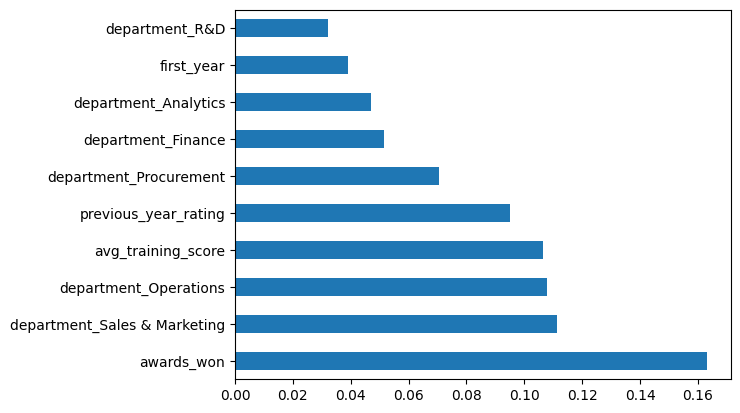

In [45]:
s=pd.Series(xgb.feature_importances_, index=x_train.columns)
s.rename({"tnf2__department_R&D":"department_R&D","tnf2__department_Analytics":"department_Analytics","tnf2__department_Finance":"department_Finance",
"tnf2__department_Sales & Marketing":"department_Sales & Marketing","tnf2__department_Procurement":"department_Procurement",
"tnf2__department_Operations":"department_Operations","tnf2__first_year_1.0":"first_year",
"remainder__previous_year_rating":"previous_year_rating","remainder__awards_won":"awards_won","remainder__avg_training_score":"avg_training_score"},inplace=True)
s.nlargest(10).plot(kind='barh')
